In [1]:
import os
import time
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
# from torch import cdist
# import glob

In [2]:
from dtaidistance import dtw

In [3]:
from dotenv import load_dotenv
from databricks import sql
# from numba import jit

In [4]:
from helpers import *

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.python.framework.errors_impl import InvalidArgumentError
import tensorflow as tf

In [7]:
from catboost import CatBoostRegressor
from hmmlearn import hmm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import NearestNeighbors
import math
# from statsmodels.tsa.arima.model import ARIMA

In [8]:
ROOT_DIR = Path().cwd()
while not ROOT_DIR.joinpath("data").exists():
    ROOT_DIR = ROOT_DIR.parent
os.chdir(ROOT_DIR)

In [9]:
from data import EncoderFactory
from data import DatasetManager

AMBR
CSL312
Astrazeneca
bpic2011_f1
bpic2011_f2
bpic2011_f3
bpic2011_f4


In [10]:
case_id_col = "UID"
timestamp_col = "timestamp"
target_col = "titre(g/l)"
work_day_col = "working day"

In [11]:
df = pd.read_csv('data/processed/ambr_preprocessed.csv')
df[case_id_col].nunique()

114

In [12]:
df

,glutamate(g/l),UID,ammonia(g/l),viable cell density(1e6 cells/ml),lactate(g/l),ph,glucose(g/l),glutamine(g/l),working day,viability(%),titre(g/l),timestamp
0,0.328100,X5272_1,0.007576,0.4977,0.18,7.518035,6.12,0.046765,0,98.1579,NaN,2019-08-15
1,0.169200,X5272_1,0.000000,1.0033,0.51,7.473426,6.07,0.046765,1,98.5583,NaN,2019-08-16
2,0.406079,X5272_1,0.025434,2.4509,1.09,7.315561,5.00,0.062840,2,98.6044,NaN,2019-08-17
3,0.467873,X5272_1,0.040406,5.6209,2.40,6.919863,3.15,0.137372,3,97.9084,NaN,2019-08-18
4,0.526725,X5272_1,0.048343,10.5987,2.93,6.892140,4.19,0.140294,4,97.7362,NaN,2019-08-19
...,...,...,...,...,...,...,...,...,...,...,...,...
1777,0.545852,X5363_9,0.041128,7.4617,2.02,7.006278,1.48,0.263052,10,84.4259,1.770021,2019-08-25
1778,0.545852,X5363_9,0.058264,5.9781,1.74,6.949349,1.64,0.263052,11,76.3473,1.786633,2019-08-26
1779,0.545852,X5363_9,0.062052,5.8575,1.55,6.993632,0.69,0.263052,12,71.2714,2.046050,2019-08-27
1780,0.545852,X5363_9,0.064938,4.5045,0.99,7.141263,0.07,0.263052,13,64.1087,2.231495,2019-08-28


In [13]:
df = df.sort_values(by=[case_id_col, work_day_col])

In [14]:
null_ids = df[df[target_col].isnull()][case_id_col].unique()


In [15]:
df = df[~df[case_id_col].isin(null_ids)]

In [16]:
df[case_id_col].nunique()

90

In [17]:
df.columns

Index(['glutamate(g/l)', 'UID', 'ammonia(g/l)',
       'viable cell density(1e6 cells/ml)', 'lactate(g/l)', 'ph',
       'glucose(g/l)', 'glutamine(g/l)', 'working day', 'viability(%)',
       'titre(g/l)', 'timestamp'],
      dtype='object')

##############################################################################

In [18]:
df_normalized = df.copy()

In [19]:
columns_to_normalize = ['glutamate(g/l)', 'ammonia(g/l)',
       'viable cell density(1e6 cells/ml)', 'lactate(g/l)', 'ph',
       'glucose(g/l)', 'glutamine(g/l)','viability(%)',
       'titre(g/l)']

In [20]:
features = [x for x in columns_to_normalize if x != target_col]
print(features)  

['glutamate(g/l)', 'ammonia(g/l)', 'viable cell density(1e6 cells/ml)', 'lactate(g/l)', 'ph', 'glucose(g/l)', 'glutamine(g/l)', 'viability(%)']


In [21]:

# Assuming your data is stored in a DataFrame called 'data'
average_max_work_day = data.groupby(case_id_col)[work_day_col].max().mean()

print("Average Maximum work_day_col:", average_max_work_day)


NameError: name 'data' is not defined

In [22]:
UIDs = df_normalized[case_id_col].unique()

In [23]:
from sklearn.preprocessing import StandardScaler

scalers = {}
# Create a StandardScaler object
scaler = StandardScaler()

for column in columns_to_normalize:
    scalers[column] = StandardScaler()
    df_normalized[column] = scalers[column].fit_transform(df_normalized[[column]])

# Normalize the selected columns
# df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])


In [24]:

method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

In [30]:
df = pd.read_csv('data/processed/databricks_preprocessed_forTiter_normalised_withClusters_10Feb25.csv')

In [45]:
df_normalized.drop(columns=['Titer (g/L) original', 'Cluster'], inplace=True)
# df.drop(columns=['range_indicator'], inplace=True)

In [42]:
df_normalized = pd.read_csv('data/processed/CSL312_preprocessed_forTiter_normalised_6Feb25.csv')

In [48]:
df_normalized.columns

Index(['Identification No.', 'Time (hrs)',
       'Product Content pre clean up (g/L)', 'Working Day (d)', 'BR Temp (°C)',
       'pH (Internal)', 'Viability (%)', 'VCD (10^6 cells/mL)',
       'Glucose (g/L)', 'Lactate (g/L)', 'Ca2+ (g/L)', 'Glutamine (g/L)',
       'Glutamate (g/L)', 'Na+ (g/L)', 'K+ (g/L)', 'NH4+ (g/L)'],
      dtype='object')

In [49]:
import hashlib

df_normalized['Identification No.'] = df_normalized['Identification No.'].apply(lambda x: hashlib.sha256(str(x).encode()).hexdigest())


In [50]:
df_normalized

,Identification No.,Time (hrs),Product Content pre clean up (g/L),Working Day (d),BR Temp (°C),pH (Internal),Viability (%),VCD (10^6 cells/mL),Glucose (g/L),Lactate (g/L),Ca2+ (g/L),Glutamine (g/L),Glutamate (g/L),Na+ (g/L),K+ (g/L),NH4+ (g/L)
0,eac4c7a9387af7885a6eac0d7e662ec6ba71ab4ebff047...,0.75,-1.087131,0,1.056810,1.327097,0.537907,-1.635679,1.621778,-1.195156,-0.007709,-0.793751,0.313125,0.585203,-2.197873,-1.826047
1,eac4c7a9387af7885a6eac0d7e662ec6ba71ab4ebff047...,22.28,-1.042176,1,1.031827,1.327097,0.558432,-1.557811,1.406825,-0.994354,-0.007709,-0.793751,0.374743,0.690240,-2.211087,-1.476049
2,eac4c7a9387af7885a6eac0d7e662ec6ba71ab4ebff047...,46.08,-1.003795,2,1.031827,-0.012148,0.650795,-1.352296,0.659161,-0.426871,-0.007709,-0.344009,0.297720,0.752027,-2.164839,-0.795498
3,eac4c7a9387af7885a6eac0d7e662ec6ba71ab4ebff047...,69.65,-0.926388,3,1.031827,-1.351394,0.650795,-0.968536,-0.153923,0.062037,-0.006285,0.426978,0.328529,0.677883,-2.170124,0.001719
4,eac4c7a9387af7885a6eac0d7e662ec6ba71ab4ebff047...,93.63,-0.775909,4,1.021833,-1.649004,0.671320,-0.469905,-1.275418,0.044576,-0.002012,0.459102,0.058951,1.023889,-2.162196,0.643381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,6043d134d5716658e65a69bf75eec99b33ca07dce1d902...,188.78,0.885811,8,-0.966839,0.136657,0.363444,1.104122,0.350750,-0.147495,-0.031921,-0.568880,-1.034768,0.165052,0.566476,-0.231613
1942,6043d134d5716658e65a69bf75eec99b33ca07dce1d902...,214.63,1.397926,9,-1.016806,0.434267,0.240294,1.168448,-1.125885,-0.531637,-0.033345,-0.761627,-1.050173,0.183588,0.731650,-0.464945
1943,6043d134d5716658e65a69bf75eec99b33ca07dce1d902...,238.02,1.676235,10,-0.966839,0.186259,-0.242045,1.118220,0.528320,-0.627673,-0.034769,-0.793751,-1.050173,0.016764,0.665580,-0.445501
1944,6043d134d5716658e65a69bf75eec99b33ca07dce1d902...,262.90,2.189987,11,-0.966839,0.632674,-0.847534,1.062861,-0.882895,-0.601481,-0.031921,-0.793751,-1.050173,-0.267455,0.641795,-0.445501


In [51]:
df_normalized.to_csv('data/processed/CSL312_anonymised_normalised.csv', index=False)

In [23]:
from processors.AMBRProcessor import AMBRProcessor
# from data.dataset_confs import dataset_configs

# config = dataset_configs['CSL_5L']
results = []
use_encoding = False
use_bucketing = False
num_nearest_neighbors = 400
distance_metric = 'cosine_expotential'

processor = AMBRProcessor("AMBR", use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)

In [28]:
############ baseline ############
results = []
method = 'Catboost'
config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = processor.split_data(data, train_ratio=0.5, split="temporal")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([timestamp_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features


for index, row in current.iterrows():

    target = historic['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0, random_state=123)
        model.fit(historic[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(historic[features_used])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    row['predicted_value'] = preds
    results.append(row)
    

In [29]:
baseline_results = pd.DataFrame(results)
# .to_csv(f'data/processed/predictions_{method}_{config}.csv', index=False)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(baseline_results["Target"], baseline_results["predicted_value"])

# Calculate MSE
mse = mean_squared_error(baseline_results["Target"], baseline_results["predicted_value"], squared=True)

# Calculate RMSE
rmse = mean_squared_error(baseline_results["Target"], baseline_results["predicted_value"], squared=False)

# Calculate R2
r2 = r2_score(baseline_results["Target"], baseline_results["predicted_value"])

# Calculate MAPE
mape = mean_absolute_percentage_error(baseline_results["Target"], baseline_results["predicted_value"])

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)
print("MAPE:", mape)


MAE: 0.391159610128279
MSE: 0.37356086475686084
RMSE: 0.6111962571522022
R2: 0.6711037715008926
MAPE: 0.6198759090047311


In [35]:
baseline_results.to_csv(f'results/AMBR/baseline_{method}_{config}_{num_nearest_neighbors}_{distance_metric}.csv', index=False)

In [43]:
from processors import processor_factory

In [52]:
dataset_name = 'AMBR'

In [53]:
# Define the values to experiment with
num_nearest_neighbors_values = [100, 200, 300, 400]
distance_metrics = ['euclidean', 'cosine', 'chebyshev']

results = []
# Loop through the values and create processors
for num_nearest_neighbors in num_nearest_neighbors_values:
    for distance_metric in distance_metrics:
        print(f"Experimenting with num_nearest_neighbors={num_nearest_neighbors} and distance_metric={distance_metric}")
        
        # Create the processor with the current values
        # processor = processor_factory.get_processor(dataset_name, use_encoding=False, use_bucketing=False, num_nearest_neighbors=num_nearest_neighbors, distance_metric=distance_metric)
        processor = AMBRProcessor("AMBR", use_encoding, use_bucketing, num_nearest_neighbors, distance_metric)
    

        data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
        data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
        # data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
        data['Target'] = data.groupby(case_id_col)['Target'].ffill().bfill()
        # data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

        historic, current = processor.split_data(data, train_ratio=0.5, split="temporal")
        historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
        current.sort_values(timestamp_col, ascending=True, kind='mergesort', inplace=True)

        if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
            features_used = features + ['Cluster']
        else:
            features_used = features

        # n_neighbors = 200
        # # Initialize the NearestNeighbors model
        # nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
        # # Fit the model on the historic data
        # nn_model.fit(historic[features_used])

        batch_size = 50

        nn_model = processor.train_nn_model(historic[features_used])

        for start in range(0, len(current), batch_size):
            end = start + batch_size
            batch = current.iloc[start:end]
            # Find the n nearest neighbors for the selected row
            # distances, indices = nn_model.kneighbors([row[features_used]])
            distances, indices = processor.find_nearest_neighbors(nn_model, batch[features_used])
            nearest_neighbors = pd.concat([historic.iloc[indices[i]] for i in range(len(batch))])

            target = nearest_neighbors['Target'].values
            target_test = batch['Target']

            if target_test is None:
                continue
            

            if method == 'Catboost':
                # Create the CatBoostRegressor model
                model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
                model.fit(nearest_neighbors[features_used], target)

            if method == 'HMM':
                # Create an instance of the HMM model
                model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
                model.fit(nearest_neighbors[features_used])

            # Make predictions on the testing data
            preds = model.predict(batch[features_used])

            # true_conc_glu = row['Target_orig']
            # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))

            batch.loc[:, 'predicted_value'] = preds

            results.append(batch)

            # Add the current row with its prediction to the historic data
            # row_with_prediction[target_col] = preds_scaled[0][0]
            historic = pd.concat([historic, batch], ignore_index=True)
            historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
            nn_model =processor.train_nn_model(historic[features_used])  # Refit the model with the updated historic data

        results_df = pd.concat(results)
        results = []

        # Calculate metrics
        true_values = results_df[target_col]
        predicted_values = results_df['predicted_value']

        MAE_t = mean_absolute_error(true_values, predicted_values)
        MSE_t = mean_squared_error(true_values, predicted_values)
        RMSE_t = math.sqrt(MSE_t)
        r2_t = r2_score(true_values, predicted_values)
        mape_t = mean_absolute_percentage_error(true_values, predicted_values)

        # Save results to a CSV file
        # results_df.to_csv('predictions_with_row_data.csv', index=False)

        # Print metrics
        print(f"MAE: {MAE_t}")
        print(f"MSE: {MSE_t}")
        print(f"RMSE: {RMSE_t}")
        print(f"R2: {r2_t}")
        print(f"MAPE: {mape_t}")

        results_df.to_csv(f'results/{dataset_name}/AMBR_{method}_{config}_{num_nearest_neighbors}_{distance_metric}.csv', index=False)
        print('***********************************')


Experimenting with num_nearest_neighbors=100 and distance_metric=euclidean
MAE: 0.16959364293793092
MSE: 0.06386230233056991
RMSE: 0.25270991735697657
R2: 0.9464420376738679
MAPE: 0.7218010960332537
***********************************
Experimenting with num_nearest_neighbors=100 and distance_metric=cosine
MAE: 0.18029104938886764
MSE: 0.0704507395624542
RMSE: 0.2654255819668749
R2: 0.940916661040454
MAPE: 0.7150634087908665
***********************************
Experimenting with num_nearest_neighbors=100 and distance_metric=chebyshev
MAE: 0.17771685406299725
MSE: 0.07136863625956893
RMSE: 0.26714908994710973
R2: 0.9401468692395121
MAPE: 0.660778486287254
***********************************
Experimenting with num_nearest_neighbors=200 and distance_metric=euclidean
MAE: 0.17561818749379055
MSE: 0.06774205098632372
RMSE: 0.26027303161550125
R2: 0.9431882960335473
MAPE: 0.7046042928673665
***********************************
Experimenting with num_nearest_neighbors=200 and distance_metric=co

In [26]:
results

[      glutamate(g/l)       UID  ammonia(g/l)  \
 1044       -0.258619  X5356_12     -0.984814   
 1062       -0.204529  X5356_13     -0.993470   
 1080        0.018591  X5356_14     -1.149280   
 1098        0.106487  X5356_15     -1.114656   
 1116        0.005069  X5356_16     -1.097343   
 1134       -0.021976  X5356_17     -1.080031   
 1152       -0.157201  X5356_18     -1.088687   
 1170       -0.069305  X5356_19     -1.036750   
 1188        0.241711   X5356_2     -1.054063   
 1206       -0.136917  X5356_20     -1.036750   
 1224       -0.021976  X5356_21     -0.976158   
 1242       -1.698756  X5356_22     -1.400308   
 1260        0.566249  X5356_23     -0.292324   
 1278        0.600055  X5356_24     -0.266355   
 1296        0.106487   X5356_3     -1.201217   
 1314        0.011830   X5356_4     -1.209873   
 1332       -0.130156   X5356_5     -0.820347   
 1350       -0.096350   X5356_6     -0.803035   
 1368       -0.569634   X5356_7     -1.140624   
 1386       -0.17072

In [27]:
results_df = pd.concat(results)

# Calculate metrics
true_values = results_df[target_col]
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

MAE: 0.25137150042578793
MSE: 0.12488481023715871
RMSE: 0.35339045012161646
R2: 0.895265661936742
MAPE: 0.7176649660511947


In [34]:
results_df.to_csv(f'results/AMBR/AMBR_{method}_{config}_{num_nearest_neighbors}_{distance_metric}.csv', index=False)

In [ ]:
results_df_400 = pd.read_csv('results/New_Catboost_no_encoding_no_bucketing_400_dtw.csv')
results_df_300 = pd.read_csv('results/New_Catboost_no_encoding_no_bucketing_300_dtw.csv')
results_df_200 = pd.read_csv('results/New_Catboost_no_encoding_no_bucketing_200_dtw.csv')
results_df_100 = pd.read_csv('results/New_Catboost_no_encoding_no_bucketing_100_dtw.csv')

In [ ]:
for file in files:
    print(file)

In [31]:
import matplotlib.pyplot as plt

In [32]:
def calculate_moving_avg_mae(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    mae_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        mae = mean_absolute_error(true_values[:i], predicted_values[:i])
        mae_list.append(mae)

    mae_df = pd.DataFrame({'num_rows': num_rows_list, 'mae': mae_list})
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()
    
    return mae_df

In [71]:
# Function to calculate MAE
def calculate_mae(df, target_col, predicted_col):
    return np.mean(np.abs(df[target_col] - df[predicted_col]))

# List to store MAE values and corresponding file names
mae_list = []

results_folder = 'results/AMBR'  # Replace with the path to your results folder
target_col = "Target"
# target_col = "Product Content pre clean up (g/L)"

# Get the list of files in the results folder
files = os.scandir(results_folder)


# Loop through each file
for file in files:
    if not file.name.startswith('.') and file.is_file():
        df = pd.read_csv(file.path)
        # df = df.tail(722)
        
        # Calculate the MAE for the file
        # mae = calculate_mae(df, target_col, 'predicted_value')
        mae = mean_absolute_error(df[target_col], df['predicted_value'])
        
        # Append the MAE and file name to the list
        mae_list.append((mae, file.name))

mae_list.sort(key=lambda x: x[0], reverse=False)

# Extract the top 4 file names with the lowest MAE
top_4_files = [file_name for _, file_name in mae_list[:4]]


In [72]:
top_4_files

['AMBR_Catboost_no_encoding_no_bucketing_300_cosine.csv',
 'AMBR_Catboost_no_encoding_no_bucketing_200_chebyshev.csv',
 'AMBR_Catboost_no_encoding_no_bucketing_400_cosine.csv',
 'AMBR_Catboost_no_encoding_no_bucketing_200_euclidean.csv']

In [60]:
# Mapping of filenames to desired labels
filename_to_label = {
    'Astra_Catboost_no_encoding_no_bucketing_400_chebyshev.csv': 'Chebyshev with 400 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_100_cosine.csv': 'Cosine with 100 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_400_euclidean.csv': 'Euclidean with 400 neighbors',
    'Astra_Catboost_no_encoding_no_bucketing_300_cosine.csv': 'Cosine with 300 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_100_cosine.csv': 'Cosine with 100 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_300_euclidean.csv': 'Euclidean with 300 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_300_chebyshev.csv': 'Chebyshev with 300 neighbors',
    'CSL312_Catboost_no_encoding_no_bucketing_400_euclidean.csv': 'Euclidean with 400 neighbors',
    'New_Catboost_no_encoding_no_bucketing_400_chebyshev.csv' : 'Chebyshev with 400 neighbors',
    'New_Catboost_no_encoding_no_bucketing_300_chebyshev.csv' : 'Chebyshev with 300 neighbors',
    'New_Catboost_no_encoding_no_bucketing_400_euclidean.csv' : 'Euclidean with 400 neighbors',
    'New_Catboost_no_encoding_no_bucketing_200_chebyshev.csv': 'Chebyshev with 200 neighbors',
    'AMBR_Catboost_no_encoding_no_bucketing_300_cosine.csv': 'Cosine with 300 neighbors',
    'AMBR_Catboost_no_encoding_no_bucketing_200_chebyshev.csv': 'Chebyshev with 200 neighbors',
    'AMBR_Catboost_no_encoding_no_bucketing_400_cosine.csv': 'Cosine with 400 neighbors',
    'AMBR_Catboost_no_encoding_no_bucketing_200_euclidean.csv': 'Euclidean with 200 neighbors',
    # Add more mappings as needed
}

In [ ]:
top_4_files = ['New_Catboost_no_encoding_no_bucketing_100_cosine.csv', 'New_Catboost_no_encoding_no_bucketing_300_cosine.csv', 'New_Catboost_no_encoding_no_bucketing_400_euclidean.csv', 'New_Catboost_no_encoding_no_bucketing_400_cosine.csv']

['AMBR_Catboost_no_encoding_no_bucketing_200_cosine.csv', 'AMBR_Catboost_no_encoding_no_bucketing_400_cosine.csv', 'AMBR_Catboost_no_encoding_no_bucketing_300_cosine.csv', 'AMBR_Catboost_no_encoding_no_bucketing_200_chebyshev.csv', 'AMBR_Catboost_no_encoding_no_bucketing_100_euclidean.csv', 'AMBR_Catboost_no_encoding_no_bucketing_300_chebyshev.csv', 'AMBR_Catboost_no_encoding_no_bucketing_400_chebyshev.csv', 'baseline_Catboost_no_encoding_no_bucketing_400_cosine_expotential.csv', 'AMBR_Catboost_no_encoding_no_bucketing_300_euclidean.csv', 'AMBR_Catboost_no_encoding_no_bucketing_100_chebyshev.csv', 'AMBR_Catboost_no_encoding_no_bucketing_400_euclidean.csv', 'AMBR_Catboost_no_encoding_no_bucketing_400_cosine_expotential.csv', 'AMBR_Catboost_no_encoding_no_bucketing_100_cosine.csv', 'AMBR_Catboost_no_encoding_no_bucketing_200_euclidean.csv']
AMBR_Catboost_no_encoding_no_bucketing_300_cosine.csv
(737, 3)
AMBR_Catboost_no_encoding_no_bucketing_200_chebyshev.csv
(737, 3)
AMBR_Catboost_no_enc

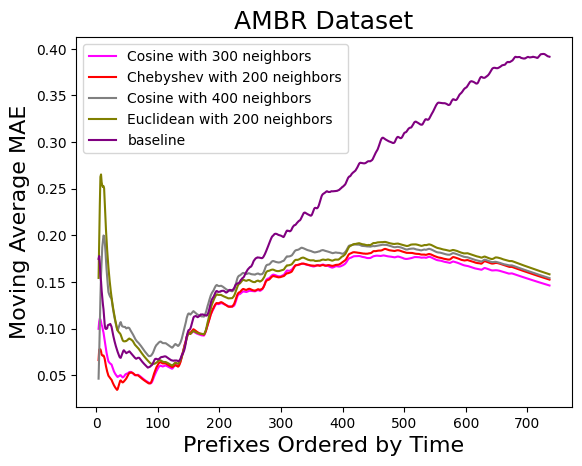

In [73]:
results_folder = 'results/AMBR'  # Replace with the path to your results folder

# Get the list of files in the results folder
files = os.scandir(results_folder)
# Get scandir object
with os.scandir(results_folder) as entries:
    # Extract file names
    file_names = [entry.name for entry in entries if entry.is_file() & entry.name.endswith('.csv')]

# Print the file names as a string
print(file_names)

# Create a figure to display all the plots
# fig, ax = plt.subplots()
plt.figure()

# Loop through each file
for file in top_4_files:
    print(str(file))
    df = pd.read_csv(results_folder+"/"+file)
    # df = df.tail(1041)
    df = df.sort_values(timestamp_col)
    
    # Plot the moving average MAE
    # Calculate the moving average
    window_size = 5
    moving_avg = calculate_moving_avg_mae(df, target_col, 'predicted_value')
    
    print(moving_avg.shape)
    # Plot the original values and the moving average
    label = filename_to_label.get(file, file)  # Get the custom label or default to filename
    if label == 'Chebyshev with 200 neighbors':
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='red')
    elif label == 'Cosine with 400 neighbors':
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='gray')
    elif label == 'Cosine with 300 neighbors':
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='magenta')
    elif label == 'Euclidean with 200 neighbors':
        plt.plot(moving_avg['moving_avg_mae'], label=label, color='olive')
    else:
        plt.plot(moving_avg['moving_avg_mae'], label=label)
    # plt.legend(fontsize='small')
  

    # Set the labels and title for the plot
    # ax.set_xlabel('Time')
    # ax.set_ylabel('Moving Average MAE')
    # ax.set_title('Moving Average MAE for Each File')
    # ax.legend()

    # Display the plot
baseline_results = baseline_results.sort_values(timestamp_col)
moving_avg_baseline = calculate_moving_avg_mae(baseline_results, target_col, 'predicted_value', window_size=5)
plt.plot(moving_avg_baseline['moving_avg_mae'], label='baseline', color='purple')
plt.legend(fontsize='medium')

# Set labels
plt.xlabel("Prefixes Ordered by Time", fontsize=16)
plt.ylabel("Moving Average MAE", fontsize=16)
plt.title("AMBR Dataset", fontsize=18)
plt.show()

# Save the figure in high quality
# plt.savefig('figure.png', dpi=400)
# plt.savefig('AMBR.pdf', format='pdf')


In [ ]:
for file in top_4_files:
    tmp = pd.read_csv(f'results/{file}')
    # Calculate metrics
    true_values = tmp[target_col]
    predicted_values = tmp['predicted_value']

    MAE_t = mean_absolute_error(true_values, predicted_values)
    MSE_t = mean_squared_error(true_values, predicted_values)
    RMSE_t = math.sqrt(MSE_t)
    r2_t = r2_score(true_values, predicted_values)
    mape_t = mean_absolute_percentage_error(true_values, predicted_values)

    # Save results to a CSV file
    # results_df.to_csv('predictions_with_row_data.csv', index=False)

    # Print metrics
    print(f"MAE: {MAE_t}")
    print(f"MSE: {MSE_t}")
    print(f"RMSE: {RMSE_t}")
    print(f"R2: {r2_t}")
    print(f"MAPE: {mape_t}")

In [ ]:
tmp.tail(1041)[work_day_col].describe()

In [74]:
tmp = pd.read_csv('results/New_Catboost_no_encoding_no_bucketing_300_cosine.csv')


In [80]:
# Calculate metrics
true_values = tmp[target_col]
predicted_values = tmp['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

MAE: 0.24705038672885973
MSE: 0.27228320401853867
RMSE: 0.5218076312383124
R2: 0.7686180237981541
MAPE: 0.6401030765186212


In [84]:
work_day_values = tmp['Work_Day_Index'].unique()
phases = ['lag', 'Exponential', 'plateau']
dat = pd.DataFrame(columns=['Working Day', 'MAE', 'MSE', 'RMSE'])
for phase in phases:
    if phase == 'lag':
        work_day_phase = work_day_values[:3]
    elif phase == 'Exponential':
        work_day_phase = work_day_values[3:6]
    else:
        work_day_phase = work_day_values[6:]
    work_day_data = tmp[tmp['Work_Day_Index'].isin(work_day_phase)]
    predicted_values = work_day_data['predicted_value']
    target_values = work_day_data['Target']
    
    mae = np.mean(np.abs(predicted_values - target_values))
    mse = np.mean((predicted_values - target_values) ** 2)
    rmse = np.sqrt(mse)
    
    new_row = pd.DataFrame({'Working Day': [phase], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
    dat = pd.concat([dat, new_row], ignore_index=True)
    
    print(f"Phase: {phase}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print()


Phase: lag
MAE: 0.04466220332919408
MSE: 0.008302472688910772
RMSE: 0.09111790542429503

Phase: Exponential
MAE: 0.12023659393863242
MSE: 0.046451889361347955
RMSE: 0.21552700378687575

Phase: plateau
MAE: 0.3408952939685124
MSE: 0.4119128822862743
RMSE: 0.6418043956582677



In [85]:
work_day_values = baseline_results[work_day_col].unique()
phases = ['lag', 'Exponential', 'plateau']
dat2 = pd.DataFrame(columns=['Working Day', 'MAE', 'MSE', 'RMSE'])
for phase in phases:
    if phase == 'lag':
        work_day_phase = work_day_values[:3]
    elif phase == 'Exponential':
        work_day_phase = work_day_values[3:6]
    else:
        work_day_phase = work_day_values[6:]
    work_day_data = baseline_results[baseline_results[work_day_col].isin(work_day_phase)]
    predicted_values = work_day_data['predicted_value']
    target_values = work_day_data['Target']
    
    mae = np.mean(np.abs(predicted_values - target_values))
    mse = np.mean((predicted_values - target_values) ** 2)
    rmse = np.sqrt(mse)
    
    new_row = pd.DataFrame({'Working Day': [phase], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse]})
    dat2 = pd.concat([dat2, new_row], ignore_index=True)
    
    print(f"Phase: {phase}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print()

Phase: lag
MAE: 0.06448978247836294
MSE: 0.01439299100835569
RMSE: 0.11997079231361144

Phase: Exponential
MAE: 0.28598330639663705
MSE: 0.18154888982193002
RMSE: 0.4260855428454831

Phase: plateau
MAE: 0.5157306095652668
MSE: 0.5325550518770829
RMSE: 0.7297636959160704



In [86]:
dat

,Working Day,MAE,MSE,RMSE
0,lag,0.044662,0.008302,0.091118
1,Exponential,0.120237,0.046452,0.215527
2,plateau,0.340895,0.411913,0.641804


In [88]:
dat2

,Working Day,MAE,MSE,RMSE
0,lag,0.064490,0.014393,0.119971
1,Exponential,0.285983,0.181549,0.426086
2,plateau,0.515731,0.532555,0.729764


In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_400['row_data'])

# Drop the original row_data column from results_df_baseline
tmp = results_df_400.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp = pd.concat([tmp, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp = tmp[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_300['row_data'])

# Drop the original row_data column from results_df_baseline
tmp2 = results_df_300.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp2 = pd.concat([tmp2, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp2 = tmp2[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_200['row_data'])

# Drop the original row_data column from results_df_baseline
tmp3 = results_df_200.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp3 = pd.concat([tmp3, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp3 = tmp3[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_100['row_data'])

# Drop the original row_data column from results_df_baseline
tmp4 = results_df_100.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp4 = pd.concat([tmp4, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp4 = tmp4[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def calculate_moving_avg_mae(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    mae_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        mae = mean_absolute_error(true_values[:i], predicted_values[:i])
        mae_list.append(mae)

    mae_df = pd.DataFrame({'num_rows': num_rows_list, 'mae': mae_list})
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()
    
    return mae_df

# Calculate moving average MAE for tmp
mae_df_tmp = calculate_moving_avg_mae(results_df_400, target_col, 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp2 = calculate_moving_avg_mae(results_df_300, target_col, 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp3 = calculate_moving_avg_mae(results_df_200, target_col, 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp4 = calculate_moving_avg_mae(results_df_100, target_col, 'predicted_value')

# Plot the moving average MAE for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(mae_df_tmp['num_rows'], mae_df_tmp['moving_avg_mae'], label='400', color='blue')
plt.plot(mae_df_tmp2['num_rows'], mae_df_tmp2['moving_avg_mae'], label='300', color='red')
# plt.plot(mae_df_tmp3['num_rows'], mae_df_tmp3['moving_avg_mae'], label='200', color='green')
# plt.plot(mae_df_tmp4['num_rows'], mae_df_tmp4['moving_avg_mae'], label='100', color='black')
plt.xlabel('Number of Observed Rows')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average MAE')
plt.title('CSL 5L')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
######### without batch processing #########
data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill()
data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = processor.split_data(data, train_ratio=0.5, split="temporal")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([timestamp_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features

# n_neighbors = 200
# # Initialize the NearestNeighbors model
# nn_model = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine")
# # Fit the model on the historic data
# nn_model.fit(historic[features_used])

nn_model = processor.train_nn_model(historic[features_used])

for index, row in current.iterrows():
    # Find the n nearest neighbors for the selected row
    # distances, indices = nn_model.kneighbors([row[features_used]])
    distances, indices = processor.find_nearest_neighbors(nn_model, [row[features_used]])
    nearest_neighbors = historic.iloc[indices[0]]

    target = nearest_neighbors['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
        model.fit(nearest_neighbors[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    # true_conc_glu = row['Target_orig']
    # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))

    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': row['Target'],
        'predicted_value': preds
    })

    # Add the current row with its prediction to the historic data
    row_with_prediction = row.copy()
    # row_with_prediction[target_col] = preds_scaled[0][0]
    historic = pd.concat([historic, pd.DataFrame([row_with_prediction])], ignore_index=True)
    historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
    nn_model =processor.train_nn_model(historic[features_used])  # Refit the model with the updated historic data

In [ ]:
min_prefix_length = 1
max_prefix_length = df_normalized[work_day_col].max()

In [ ]:
dataset_manager = DatasetManager("5L")

In [ ]:
start_test_prefix_generation = time.time()
dt_prefixes = dataset_manager.generate_prefix_data(df_normalized, min_prefix_length, max_prefix_length)
test_prefix_generation_time = time.time() - start_test_prefix_generation

In [ ]:
dt_prefixes

In [ ]:
# Remove both EncoderFactory and AggregateTransformer from sys.modules
modules_to_remove = ['EncoderFactory', 'transformers.AggregateTransformer', 'DatasetManager']
for module in modules_to_remove:
    if module in sys.modules:
        del sys.modules[module]

# Re-import the modules
import EncoderFactory
import transformers.AggregateTransformer
import DatasetManager
from DatasetManager import DatasetManager

# Reload the modules
importlib.reload(transformers.AggregateTransformer)
importlib.reload(EncoderFactory)
# importlib.reload(DatasetManager)

In [ ]:
encoder = EncoderFactory.get_encoder(method='agg', case_id_col=case_id_col, static_cat_cols=None, static_num_cols=None, dynamic_cat_cols=['Cluster'],
                dynamic_num_cols=features, fillna=True, max_events=None, activity_col=None, resource_col=None, timestamp_col=timestamp_col,
                scale_model=None)

In [ ]:
dt_transformed = encoder.transform(dt_prefixes)
dt_transformed.columns

In [ ]:
results = []
method = 'Catboost'
# config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
config = 'encoding_bucketing'

data = dt_prefixes.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
# data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
# data['Target'] = data.groupby(case_id_col)['Target'].ffill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = split_data(data, train_ratio=0.5, split="temporal")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([timestamp_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features

# Initialize the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=200)
# Fit the model on the historic data
nn_model.fit(historic[features_used])

for index, row in current.iterrows():
    # Find the n nearest neighbors for the selected row
    distances, indices = nn_model.kneighbors([row[features_used]])
    nearest_neighbors = historic.iloc[indices[0]]

    target = nearest_neighbors['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
        model.fit(nearest_neighbors[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    true_conc_glu = row['Target_orig']
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled[0][0]
    })

    # Add the current row with its prediction to the historic data
    row_with_prediction = row.copy()
    # row_with_prediction[target_col] = preds_scaled[0][0]
    historic = pd.concat([historic, pd.DataFrame([row_with_prediction])], ignore_index=True)
    historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
    nn_model.fit(historic[features_used])  # Refit the model with the updated historic data


In [ ]:
results_df = pd.DataFrame(results)

# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
config

In [ ]:
results_df.to_csv(f'results/{method}_{config}_results.csv', index=False)

In [ ]:
results = []
method = 'Catboost'
# config = 'no_encoding_no_bucketing'
config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
# config = 'encoding_bucketing'

data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
data['Target'] = data.groupby(case_id_col)['Target'].ffill()
data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = split_data(data, train_ratio=0.5, split="temporal")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([timestamp_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features


for index, row in current.iterrows():

    target = historic['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0, random_state=123)
        model.fit(historic[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    true_conc_glu = row['Target_orig']
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled[0][0]
    })

In [ ]:
results_df = pd.DataFrame(results)
results_df

In [ ]:
# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/baseline_{method}_{config}_results.csv', index=False)

In [ ]:
results = []
method = 'Catboost'
# config = 'no_encoding_no_bucketing'
# config = 'no_encoding_bucketing'
# config = 'encoding_no_bucketing'
config = 'encoding_bucketing'

data = dt_prefixes.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
# data['Target'] = data.groupby(case_id_col)[target_col].shift(-1)
# data['Target_orig'] = data.groupby(case_id_col)['Titer (g/L) original'].shift(-1)
# data['Target'] = data.groupby(case_id_col)['Target'].ffill()
# data['Target_orig'] = data.groupby(case_id_col)['Target_orig'].ffill()

historic, current = split_data(data, train_ratio=0.5, split="temporal")
historic.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort', inplace=True)
current.sort_values([timestamp_col], ascending=True, kind='mergesort', inplace=True)

if config == 'no_encoding_bucketing' or config == 'encoding_bucketing':
    features_used = features + ['Cluster']
else:
    features_used = features


for index, row in current.iterrows():

    target = historic['Target'].values
    target_test = row['Target']

    if target_test is None:
        continue
    

    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0, random_state=123)
        model.fit(historic[features_used], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features+['Cluster']])

    # Make predictions on the testing data
    preds = model.predict(row[features_used])

    true_conc_glu = row['Target_orig']
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    
    key = row[case_id_col] + '_' + str(row[work_day_col])
    results.append({
        'key': key,
        'row_data': row.to_dict(),
        'true_value': true_conc_glu,
        'predicted_value': preds_scaled[0][0]
    })

In [ ]:
# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df.to_csv(f'results/baseline_{method}_{config}_results.csv', index=False)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential


# Ensure the data is sorted by case ID and workday
df_encoded = df_normalized.sort_values(by=[case_id_col, work_day_col])
df_encoded = df_encoded.drop([timestamp_col], axis=1)

# Function to create accumulated sequences
def create_accumulated_sequences(df):
    sequences = []
    for case_id, group in df.groupby(case_id_col):
        accumulated_data = []
        for i in range(len(group)):
            accumulated_data.append(group.iloc[:i+1].drop(columns=[case_id_col, work_day_col]).values.flatten())
            sequences.append(np.concatenate(accumulated_data))
    return sequences

# Create the accumulated sequences
sequences = create_accumulated_sequences(df_encoded)

# Pad the sequences to the same length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')

# Flatten the sequences to find unique tokens
flattened_sequences = np.concatenate(padded_sequences).flatten()

# Find unique tokens
unique_tokens = np.unique(flattened_sequences)

# Set vocab_size to the number of unique tokens plus one
vocab_size = len(unique_tokens) + 1
print(f"Vocabulary size: {vocab_size}")

# Define the embedding model
embedding_dim = 128  # Dimension of the embedding space
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
# Compile the model to avoid graph execution error
model.compile(optimizer='adam', loss='mse')
model.summary()

# Apply the embedding transformation
embedded_sequences = model.predict(padded_sequences)

In [ ]:
target_col = 'Viability (%)'

In [ ]:
df_normalized['Viability original'] = scalers[target_col].inverse_transform(df_normalized[target_col].to_numpy().reshape(-1, 1))

In [ ]:
# Calculate metrics
true_values = results_df['true_value']
predicted_values = results_df['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df_cluster = pd.DataFrame(results)
results_df_cluster

In [ ]:
# Calculate metrics
true_values = results_df_cluster['true_value']
predicted_values = results_df_cluster['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
results_df_baseline = pd.DataFrame(results)
results_df_baseline

In [ ]:
# Calculate metrics
true_values = results_df_baseline['true_value']
predicted_values = results_df_baseline['predicted_value']

MAE_t = mean_absolute_error(true_values, predicted_values)
MSE_t = mean_squared_error(true_values, predicted_values)
RMSE_t = math.sqrt(MSE_t)
r2_t = r2_score(true_values, predicted_values)
mape_t = mean_absolute_percentage_error(true_values, predicted_values)

# Save results to a CSV file
# results_df.to_csv('predictions_with_row_data.csv', index=False)

# Print metrics
print(f"MAE: {MAE_t}")
print(f"MSE: {MSE_t}")
print(f"RMSE: {RMSE_t}")
print(f"R2: {r2_t}")
print(f"MAPE: {mape_t}")

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_baseline['row_data'])

# Drop the original row_data column from results_df_baseline
tmp = results_df_baseline.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp = pd.concat([tmp, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp = tmp[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df['row_data'])

# Drop the original row_data column from results_df_baseline
tmp2 = results_df.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
tmp2 = pd.concat([tmp2, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp2 = tmp2[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
# Extract the row_data column
row_data_df = pd.json_normalize(results_df_cluster['row_data'])

# Drop the original row_data column from results_df_baseline
tmp3 = results_df_cluster.drop(columns=['row_data'])

# Concatenate the normalized row_data DataFrame with the original DataFrame
# tmp3 = pd.concat([tmp3, row_data_df], axis=1)

# Retain true_value and predicted_value columns
tmp3 = tmp3[['true_value', 'predicted_value'] + list(row_data_df.columns)]

In [ ]:
def calculate_moving_avg_mae(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    mae_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        mae = mean_absolute_error(true_values[:i], predicted_values[:i])
        mae_list.append(mae)

    mae_df = pd.DataFrame({'num_rows': num_rows_list, 'mae': mae_list})
    mae_df['moving_avg_mae'] = mae_df['mae'].rolling(window=window_size).mean()
    
    return mae_df

# Calculate moving average MAE for tmp
mae_df_tmp = calculate_moving_avg_mae(tmp, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
mae_df_tmp2 = calculate_moving_avg_mae(tmp2, 'true_value', 'predicted_value')

# Calculate moving average MAE for tmp2
# mae_df_tmp3 = calculate_moving_avg_mae(tmp3, 'true_value', 'predicted_value')

# Plot the moving average MAE for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(mae_df_tmp['num_rows'], mae_df_tmp['moving_avg_mae'], label='regular learning', color='blue')
plt.plot(mae_df_tmp2['num_rows'], mae_df_tmp2['moving_avg_mae'], label='just-in-time learning', color='red')
# plt.plot(mae_df_tmp3['num_rows'], mae_df_tmp3['moving_avg_mae'], label='just-in-time learning with bucketing', color='green')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average MAE')
plt.title('Moving Average MAE vs Number of Observed events')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def calculate_moving_avg_rmse(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    rmse_list = []

    for i in range(2, len(true_values) + 1):
        num_rows_list.append(i)
        rmse = np.sqrt(mean_squared_error(true_values[:i], predicted_values[:i]))
        rmse_list.append(rmse)

    rmse_df = pd.DataFrame({'num_rows': num_rows_list, 'rmse': rmse_list})
    rmse_df['moving_avg_rmse'] = rmse_df['rmse'].rolling(window=window_size).mean()
    
    return rmse_df

# Calculate moving average RMSE for tmp
rmse_df_tmp = calculate_moving_avg_rmse(tmp, 'true_value', 'predicted_value')

# Calculate moving average RMSE for tmp2
rmse_df_tmp2 = calculate_moving_avg_rmse(tmp2, 'true_value', 'predicted_value')

# Plot the moving average RMSE for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(rmse_df_tmp['num_rows'], rmse_df_tmp['moving_avg_rmse'], label='regular learning', color='blue')
plt.plot(rmse_df_tmp2['num_rows'], rmse_df_tmp2['moving_avg_rmse'], label='just-in-time learning', color='red')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average RMSE')
plt.title('Moving Average RMSE vs Number of Observed events')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def calculate_moving_avg_r2(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()

    num_rows_list = []
    r2_list = []

    for i in range(10, len(true_values) + 1):
        num_rows_list.append(i)
        r2 = r2_score(true_values[:i], predicted_values[:i])
        r2_list.append(r2)

    r2_df = pd.DataFrame({'num_rows': num_rows_list, 'r2': r2_list})
    r2_df['moving_avg_r2'] = r2_df['r2'].rolling(window=window_size).mean()
    
    return r2_df

# Calculate moving average R² for tmp
r2_df_tmp = calculate_moving_avg_r2(tmp, 'true_value', 'predicted_value')

# Calculate moving average R² for tmp2
r2_df_tmp2 = calculate_moving_avg_r2(tmp2, 'true_value', 'predicted_value')

# Plot the moving average R² for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(r2_df_tmp['num_rows'], r2_df_tmp['moving_avg_r2'], label='regular learning', color='blue')
plt.plot(r2_df_tmp2['num_rows'], r2_df_tmp2['moving_avg_r2'], label='just-in-time learning', color='red')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average R²')
plt.title('Moving Average R² vs Number of Observed events')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def calculate_adjusted_r2(r2, n, k):
    if n <= k + 1:
        return np.nan  # Return NaN if the calculation is not possible
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

def calculate_moving_avg_adjusted_r2(df, true_col, pred_col, window_size=5):
    true_values = df[true_col].to_numpy()
    predicted_values = df[pred_col].to_numpy()
    k = 1  # Number of predictors

    num_rows_list = []
    adjusted_r2_list = []

    for i in range(10, len(true_values) + 1):
        num_rows_list.append(i)
        r2 = r2_score(true_values[:i], predicted_values[:i])
        adjusted_r2 = calculate_adjusted_r2(r2, i, k)
        adjusted_r2_list.append(adjusted_r2)

    adjusted_r2_df = pd.DataFrame({'num_rows': num_rows_list, 'adjusted_r2': adjusted_r2_list})
    adjusted_r2_df['moving_avg_adjusted_r2'] = adjusted_r2_df['adjusted_r2'].rolling(window=window_size).mean()
    
    return adjusted_r2_df

# Calculate moving average adjusted R² for tmp
adjusted_r2_df_tmp = calculate_moving_avg_adjusted_r2(tmp, 'true_value', 'predicted_value')

# Calculate moving average adjusted R² for tmp2
adjusted_r2_df_tmp2 = calculate_moving_avg_adjusted_r2(tmp2, 'true_value', 'predicted_value')

# Plot the moving average adjusted R² for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(adjusted_r2_df_tmp['num_rows'], adjusted_r2_df_tmp['moving_avg_adjusted_r2'], label='regular learning', color='blue')
plt.plot(adjusted_r2_df_tmp2['num_rows'], adjusted_r2_df_tmp2['moving_avg_adjusted_r2'], label='just-in-time learning', color='red')
plt.xlabel('Number of Observed Rows')
plt.ylabel('Moving Average Adjusted R²')
plt.title('Moving Average Adjusted R² vs Number of Observed events')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
results = {}
method = 'Catboost'

data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
data['Target'] = data[target_col].shift(-1)
data['Target_orig'] = data['Titer (g/L) original'].shift(-1)

historic, current = split_data(data, train_ratio=0.5, split="temporal")




# df_train, df_test = split_data(data, split="loo", leave_out=[latest_case_id_col])


data = data.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
df_train = df_train.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
df_test = df_test.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)

df_without_last = df_train.groupby('UID').apply(remove_last_row).reset_index(drop=True)
df_without_last_test = df_test.groupby('UID').apply(remove_last_row).reset_index(drop=True)

target = df_without_last['Target'].values
# mask = np.isnan(target)
# target = target[~mask]

target_test = df_without_last_test['Target'].values
# mask = np.isnan(target_test)
# target_test = target_test[~mask]

if method == 'Catboost':
    # Create the CatBoostRegressor model
    model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
    model.fit(df_without_last[features+['Cluster']], target)

if method == 'HMM':
    # Create an instance of the HMM model
    model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
    model.fit(df_without_last[features+['Cluster']])

# Make predictions on the testing data
preds = model.predict(df_without_last_test[features+['Cluster']])

true_conc_glu = df_without_last_test['Target_orig'].to_numpy()
preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
# preds_scaled = np.expm1(preds)

results_folder = f'results_figures_{method}_rerun'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

plt.plot(true_conc_glu, label='True Values')
plt.plot(preds_scaled, label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Titer (g/L)')
plt.title(f'True vs Predicted Titer for UID: {bioreactor}')
plt.legend()
plt.savefig(os.path.join(results_folder, f'{bioreactor}.png'))
plt.close()

MAE_t = mean_absolute_error(true_conc_glu, preds_scaled)
MSE_t = mean_squared_error(true_conc_glu, preds_scaled)
# RMSE_g = mean_squared_error(true_conc_glu, conc_glucose, squared=False)
RMSE_t = math.sqrt(MSE_t)
r2_t = r_squared = r2_score(true_conc_glu, preds_scaled)
mape_t = mean_absolute_percentage_error(true_conc_glu, preds_scaled)

results[bioreactor] = {'titer_MAE': MAE_t, 'titer_MSE': MSE_t, 'titer_RMSE':RMSE_t, 'titer_R2': r2_t, 'titer_MAPE': mape_t}

In [ ]:
df_results = pd.DataFrame(results).T
# catboost regular
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
df_results = pd.DataFrame(results).T
# catboost regular ـ old results with fewer experiments
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
df_results = pd.DataFrame(results).T
# HMM regular 
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
import shap

In [ ]:
import shap
import matplotlib.pyplot as plt

# Assuming you have a trained model named 'model' and a dataset named 'X'
explainer = shap.Explainer(model)
shap_values = explainer(df_train[features])

# Plot feature importances
plt.figure(figsize=(10, 20)) 
shap.summary_plot(shap_values, df_train[features], plot_type='bar', show=False)
plt.show()


In [ ]:
results = {}
method = 'Catboost'
for bioreactor in UIDs:
    data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
    data['Target'] = data[target_col].shift(-1)
    data['Target_orig'] = data['Titer (g/L) original'].shift(-1)
    data['Target_log'] = np.log1p(data['Target_orig']) 
    df_train, df_test = split_data(data, split="loo", leave_out=[bioreactor])

    
    data = data.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_train = df_train.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_test = df_test.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    
    df_without_last = df_train.groupby('UID').apply(remove_last_row).reset_index(drop=True)
    df_without_last_test = df_test.groupby('UID').apply(remove_last_row).reset_index(drop=True)

    target = df_without_last['Target_log'].values
    # mask = np.isnan(target)
    # target = target[~mask]

    target_test = df_without_last_test['Target_log'].values
    # mask = np.isnan(target_test)
    # target_test = target_test[~mask]
    
    if method == 'Catboost':
        # Create the CatBoostRegressor model
        model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='MAE', verbose=0)
        model.fit(df_without_last[features], target)

    if method == 'HMM':
        # Create an instance of the HMM model
        model = hmm.GaussianHMM(n_components=7)  # Specify the number of hidden states
        model.fit(df_without_last[features])

    # Make predictions on the testing data
    preds = model.predict(df_without_last_test[features])

    true_conc_glu = df_without_last_test['Target_orig'].to_numpy()
    # preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    preds_scaled = np.expm1(preds)

    results_folder = f'results_figures_{method}_log'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    plt.plot(true_conc_glu, label='True Values')
    plt.plot(preds_scaled, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Titer (g/L)')
    plt.title(f'True vs Predicted Titer for UID: {bioreactor}')
    plt.legend()
    plt.savefig(os.path.join(results_folder, f'{bioreactor}.png'))
    plt.close()
    
    MAE_t = mean_absolute_error(true_conc_glu, preds_scaled)
    MSE_t = mean_squared_error(true_conc_glu, preds_scaled)
    # RMSE_g = mean_squared_error(true_conc_glu, conc_glucose, squared=False)
    RMSE_t = math.sqrt(MSE_t)
    r2_t = r_squared = r2_score(true_conc_glu, preds_scaled)
    mape_t = mean_absolute_percentage_error(true_conc_glu, preds_scaled)

    results[bioreactor] = {'titer_MAE': MAE_t, 'titer_MSE': MSE_t, 'titer_RMSE':RMSE_t, 'titer_R2': r2_t, 'titer_MAPE': mape_t}

In [ ]:
df_results = pd.DataFrame(results).T
# catboost regular log
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
results = {}
method = 'Catboost'
for bioreactor in UIDs:
    data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
    data['Target'] = data[target_col].shift(-1)
    data['Target_orig'] = data['Titer (g/L) original'].shift(-1)
    # df['Target'] = df['Titer (g/L) original'].shift(-1)
    # df['Target_log'] = np.log1p(df['Target']) 
    df_train, df_test = split_data(data, split="loo", leave_out=[bioreactor])

    
    data = data.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_train = df_train.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_test = df_test.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    
    df_without_last = df_train.groupby('UID').apply(remove_last_row).reset_index(drop=True)
    df_without_last_test = df_test.groupby('UID').apply(remove_last_row).reset_index(drop=True)

    target = df_without_last['Target'].values
    # mask = np.isnan(target)
    # target = target[~mask]

    target_test = df_without_last_test['Target'].values
    # mask = np.isnan(target_test)
    # target_test = target_test[~mask]

    input_data = df_without_last[features].to_numpy().reshape(-1, 1, len(features))
    input_data_test = df_without_last_test[features].to_numpy().reshape(-1, 1, len(features))
    
    # Define LSTM model
    model = Sequential()
    # model.add(Embedding(input_dim=len(features), output_dim=50, input_length=max_sequence_len))
    model.add(LSTM(units=100))
    model.add(Dense(units=1, activation='relu'))  # Change the units to 1 for regression
    # model.build(input_shape=df_without_last[features].shape)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])  # Use mean squared error loss for regression
    
    #create checkpoint during training
    checkpoint_path = f"model_checkpoints/model_checkpoints_dataBricksTiter/training_without_{bioreactor}/cp.ckpt/checkpoint.weights.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    try:
        os.makedirs(checkpoint_dir, exist_ok=True)
    except FileExistsError:
        # directory already exists
        pass

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True, verbose=1)
    
    try:
        model.fit(input_data, target, epochs=50, callbacks=[cp_callback], verbose=2)
    except InvalidArgumentError as e:
        print(e)
        continue
    
    # Loads the weights
    model.load_weights(checkpoint_path)

    # Re-evaluate the model
    loss, acc = model.evaluate(input_data_test, target_test, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    
    with open('out.txt', 'a') as f:
        print("{}, accuracy: {:5.2f}%\n".format(bioreactor, (100 * acc)), file=f)

    preds = model.predict(input_data_test)

    true_conc_glu = df_without_last_test['Target_orig'].to_numpy()
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    # preds_scaled = np.expm1(preds)

    results_folder = f'results_figures_LSTM'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    plt.plot(true_conc_glu, label='True Values')
    plt.plot(preds_scaled, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Titer (g/L)')
    plt.title(f'True vs Predicted Titer for UID: {bioreactor}')
    plt.legend()
    plt.savefig(os.path.join(results_folder, f'{bioreactor}.png'))
    plt.close()
    
    MAE_t = mean_absolute_error(true_conc_glu, preds_scaled)
    MSE_t = mean_squared_error(true_conc_glu, preds_scaled)
    # RMSE_g = mean_squared_error(true_conc_glu, conc_glucose, squared=False)
    RMSE_t = math.sqrt(MSE_t)
    r2_t = r_squared = r2_score(true_conc_glu, preds_scaled)
    mape_t = mean_absolute_percentage_error(true_conc_glu, preds_scaled)

    results[bioreactor] = {'titer_MAE': MAE_t, 'titer_MSE': MSE_t, 'titer_RMSE':RMSE_t, 'titer_R2': r2_t, 'titer_MAPE': mape_t}


In [ ]:
df_results = pd.DataFrame(results).T
# lstm regular no sequence
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
results = {}
for bioreactor in UIDs:
    data = df_normalized.sort_values([case_id_col, work_day_col], ascending=True, kind='mergesort')
    data['Target'] = data[target_col].shift(-1)
    data['Target_orig'] = data['Titer (g/L) original'].shift(-1)
    # df['Target'] = df['Titer (g/L) original'].shift(-1)
    # df['Target_log'] = np.log1p(df['Target']) 
    df_train, df_test = split_data(data, split="loo", leave_out=[bioreactor])

    
    data = data.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_train = df_train.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    df_test = df_test.groupby('UID').apply(lambda x: x.sort_values(by=work_day_col)).reset_index(drop=True)
    
    # Group by 'UID' and concatenate values of 'value' column into a string
    sequences_all =data.groupby('UID').apply(lambda x: ' '.join(str(v) for v in x['Cluster'])).tolist()
    sequences = df_train.groupby('UID').apply(lambda x: ' '.join(str(v) for v in x['Cluster'])).tolist()
    sequences_test = df_test.groupby('UID').apply(lambda x: ' '.join(str(v) for v in x['Cluster'])).tolist()
    
    df_without_last = df_train.groupby('UID').apply(remove_last_row).reset_index(drop=True)
    df_without_last_test = df_test.groupby('UID').apply(remove_last_row).reset_index(drop=True)
    
    vocab_size, max_sequence_len = get_size_max_len(sequences_all)
    input_sequences, target_sequences = tokenize_and_pad(sequences, max_sequence_len)
    input_sequences_test, target_sequences_test = tokenize_and_pad(sequences_test, max_sequence_len)

    target = df_without_last['Target'].values
    # mask = np.isnan(target)
    # target = target[~mask]

    target_test = df_without_last_test['Target'].values
    # mask = np.isnan(target_test)
    # target_test = target_test[~mask]
    
    # Define LSTM model
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_sequence_len))
    model.add(LSTM(units=100))
    model.add(Dense(units=1, activation='relu'))  # Change the units to 1 for regression
    # model.build(input_shape=df_without_last[features].shape)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])  # Use mean squared error loss for regression
    
    #create checkpoint during training
    checkpoint_path = f"model_checkpoints/model_checkpoints_dataBricksTiterCluster/training_without_{bioreactor}/cp.ckpt/checkpoint.weights.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    try:
        os.makedirs(checkpoint_dir, exist_ok=True)
    except FileExistsError:
        # directory already exists
        pass

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True, verbose=1)
    
    try:
        model.fit(input_sequences, target, epochs=50, callbacks=[cp_callback], verbose=2)
    except InvalidArgumentError as e:
        print(e)
        continue
    
    # Loads the weights
    model.load_weights(checkpoint_path)

    # Re-evaluate the model
    loss, acc = model.evaluate(input_sequences_test, target_test, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    
    with open('out.txt', 'a') as f:
        print("{}, accuracy: {:5.2f}%\n".format(bioreactor, (100 * acc)), file=f)

    preds = model.predict(input_sequences_test)

    true_conc_glu = df_without_last_test['Target_orig'].to_numpy()
    preds_scaled = scalers[target_col].inverse_transform(preds.reshape(-1, 1))
    # preds_scaled = np.expm1(preds)

    results_folder = f'results_figures_LSTM_cluster'
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    plt.plot(true_conc_glu, label='True Values')
    plt.plot(preds_scaled, label='Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Titer (g/L)')
    plt.title(f'True vs Predicted Titer for UID: {bioreactor}')
    plt.legend()
    plt.savefig(os.path.join(results_folder, f'{bioreactor}.png'))
    plt.close()
    
    MAE_t = mean_absolute_error(true_conc_glu, preds_scaled)
    MSE_t = mean_squared_error(true_conc_glu, preds_scaled)
    # RMSE_g = mean_squared_error(true_conc_glu, conc_glucose, squared=False)
    RMSE_t = math.sqrt(MSE_t)
    r2_t = r_squared = r2_score(true_conc_glu, preds_scaled)
    mape_t = mean_absolute_percentage_error(true_conc_glu, preds_scaled)

    results[bioreactor] = {'titer_MAE': MAE_t, 'titer_MSE': MSE_t, 'titer_RMSE':RMSE_t, 'titer_R2': r2_t, 'titer_MAPE': mape_t}

In [ ]:
df_results = pd.DataFrame(results).T
# lstm regular cluster sequence
pd.options.display.float_format = '{:.2f}'.format
df_results[df_results.columns].mean()

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create the model
model = Sequential()

# Add the convolutional layer
model.add(Conv2D(5, (3, 3), strides=(1, 1), padding='valid', activation='relu', input_shape=(10, 10, 1)))

# Add the max pooling layer
model.add(MaxPooling2D(pool_size=(4, 4), strides=(1, 1), padding='valid'))

# Flatten the output from the previous layer
model.add(Flatten())

# Add the fully connected layer
model.add(Dense(6, activation='relu'))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


In [ ]:
model = Sequential()
model.add(Conv2D(input_dim=10, kernel_size=3, strrides=1, padding='None'))
model.add(MaxPool2D(units=100))
model.add(Dense(units=1, activation='relu'))